In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

2025-04-03 19:34:32.733402: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import adversarial_attacks as aa

In [3]:
# Load your model and data here
model = tf.keras.applications.MobileNetV2(weights='imagenet',
                                          include_top=True) # Load the model with ImageNet weights
model.trainable = False # Freeze the model

In [4]:
# model = tf.keras.applications.MobileNetV3Large(
#     input_shape=None,
#     alpha=1.0,
#     minimalistic=False,
#     include_top=True,
#     weights='imagenet',
#     input_tensor=None,
#     classes=1000,
#     pooling=None,
#     dropout_rate=0.2,
#     classifier_activation='softmax',
#     include_preprocessing=True
# )

In [5]:
# ImageNet labels
labels = tf.keras.applications.mobilenet_v2.decode_predictions

labels

<function keras.src.applications.mobilenet_v2.decode_predictions(preds, top=5)>

In [6]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

In [7]:
################################################################################
def get_imagenet_label(probs):
   return labels(probs, top=1)[0][0]

In [27]:
################################################################################
def get_image():
    #mage_path = 'resources/YellowLabradorLooking_new.jpg'
    #image_path = 'resources/diego.jpg'
    #image_path = 'resources/paco.jpg'
    image_path = 'resources/Mountains.jpg'
    image_raw = tf.io.read_file(image_path) # reads the image file
    image = tf.image.decode_image(image_raw) # decodes image tensor
    image = preprocess(image) # custom preprocess function
    # image = tf.io.read_file('path/to/your/image.jpg')
    # image = tf.image.decode_jpeg(image, channels=3)
    # image = preprocess(image)
    return image


In [28]:
################################################################################
# def create_adversarial_pattern(input_image, input_label): # Create adversarial pattern
#   with tf.GradientTape() as tape: # GradientTape is used to record the operations for automatic differentiation
#     tape.watch(input_image) # Watch the input image for gradients
#     prediction = pretrained_model(input_image) # Get the model prediction for the input image
#     loss = loss_object(input_label, prediction) # Calculate the loss between the predicted and true label

  
#   gradient = tape.gradient(loss, input_image) # Get the gradients of the loss w.r.t to the input image.
#   signed_grad = tf.sign(gradient) # Sign of the gradient is used to create the perturbation
#   return signed_grad


In [29]:
image = get_image()  # Load your image
image_probs = model.predict(image) # returns a probability vector for the likelyhood of each class
#label = (get_imagenet_label(image_probs)[-1],) # Get the label of the image
label = (get_imagenet_label(image_probs)) # Get the label of the image

label_index = np.argmax(image_probs) # Get the index of the label

print(f"Label: {label}") # Print the label of the image
print(f"Label index: {label_index}") # Print the label index of the image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Label: ('n09193705', 'alp', 0.8995764)
Label index: 970


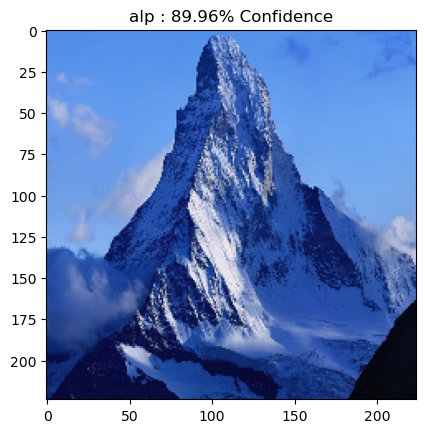

In [30]:
# show image
plt.figure() 
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs) # Get the class label and confidence score
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100)) # determined image class and confidence
plt.show()

In [31]:

# print(f"Image: {type(image)}")
# print(image.shape if hasattr(image, 'shape') else "No shape attribute")

# print(f"Label: {type(label)}")
# print(label.shape if hasattr(label, 'shape') else "No shape attribute")

aa.debug_output(image, label)

Image: <class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 224, 224, 3)
<dtype: 'float32'>
Element 0: Type = <class 'tensorflow.python.framework.ops.EagerTensor'>, dtype = <dtype: 'float32'>
Tuple: <class 'tensorflow.python.framework.ops.EagerTensor'>


Label: <class 'tuple'>
No shape attribute
('n09193705', 'alp', 0.8995764)


In [32]:
# Set epsilons
epsilons = [0.3] # Epsilon values for perturbation

# set loss function
loss_function_list = ["CategoricalCrossentropy", 
                      "SparseCategoricalCrossentropy",
                      "BinaryCrossentropy",
                      "MeanSquaredError",
                      "CosineSimilarity"]

loss_function = loss_function_list[0] # Select the loss function to use
new_label = ""

if loss_function == "CategoricalCrossentropy":
    loss_object = tf.keras.losses.CategoricalCrossentropy() # Categorical crossentropy loss function    
    image_index = label_index # Index of the label in the ImageNet dataset
    new_label = tf.one_hot(image_index, image_probs.shape[-1]) # One-hot encoding of the label
    new_label = tf.reshape(new_label, (1, image_probs.shape[-1])) # Reshape the label to match the input shape of the model

elif loss_function == "SparseCategoricalCrossentropy":
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy() # Sparse categorical crossentropy loss function
    new_label = (label[-1],)
    
elif loss_function == "BinaryCrossentropy":
    loss_object = tf.keras.losses.BinaryCrossentropy() # Binary crossentropy loss function
    
elif loss_function == "MeanSquaredError":
    loss_object = tf.keras.losses.MeanSquaredError() # Mean squared error loss function
    
elif loss_function == "CosineSimilarity":
    loss_object = tf.keras.losses.CosineSimilarity() # Cosine similarity loss function
    

print(loss_function)
print(loss_object)
print(new_label)

CategoricalCrossentropy
<LossFunctionWrapper(<function categorical_crossentropy at 0x154e89870>, kwargs={'from_logits': False, 'label_smoothing': 0.0, 'axis': -1})>
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.

In [33]:
# Generate adversarial images
fgsm_image = aa.FGSM(image, new_label, model, loss_object, epsilons)
#pgd_image = aa.PGD(image, label, model)
#cw_image = aa.CW(image, label, model)
#jsma_image = aa.JSMA(image, label, model)
#deepfool_image = aa.DeepFool(image, label, model)


Image: <class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 224, 224, 3)
<dtype: 'float32'>
Element 0: Type = <class 'tensorflow.python.framework.ops.EagerTensor'>, dtype = <dtype: 'float32'>
Tuple: <class 'tensorflow.python.framework.ops.EagerTensor'>


Label: <class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 1000)
tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Image shape: (1, 224, 224, 3)
FGSM image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Image: <class 'numpy.ndarray'>
(1, 224, 224, 3)
float32
Element 0: Type = <class 'numpy.ndarray'>, dtype = float32
Tuple: <class 'numpy.ndarray'>


Label: <class 'tuple'>
No shape attribute
('n09193705', 'alp', 0.8995764)
Image: <class 'numpy.ndarray'>
(1, 224, 224, 3)
float32
Element 0: Type = <class 'numpy.ndarray'>, dtype = float32
Tuple: <class 'numpy.ndarray'>


Label: <class 'tuple'>
No shape attribute
('n01494475', 'hammerhead', 0.27196652)
Original Label: ('n09193705', 'alp', 0.8995764)
Adversarial Label: ('n01494475', 'hammerhead', 0.27196652)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


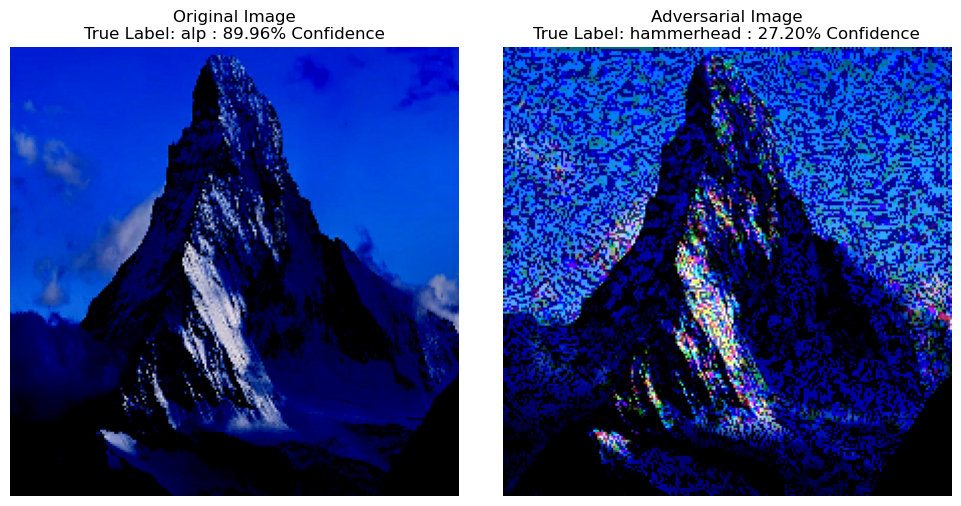

In [34]:
# Visualize the adverarial examples
aa.visualize_adversarial_examples(image, fgsm_image, labels, model)
# aa.visualize_adversarial_examples(image, pgd_image, label, model)
# aa.visualize_adversarial_examples(image, cw_image, label, model)
# aa.visualize_adversarial_examples(image, jsma_image, label, model)
# aa.visualize_adversarial_examples(image, deepfool_image, label, model)


In [35]:
# Save the original image
aa.save_adversarial_images(image, image, label, 'output/original')

# Save the adversarial images
aa.save_adversarial_images(image, fgsm_image, label, 'output/fgsm')
# aa.save_adversarial_images(image, pgd_image, label, 'output/pgd')
# aa.save_adversarial_images(image, cw_image, label, 'output/cw')
# aa.save_adversarial_images(image, jsma_image, label, 'output/jsma')
# aa.save_adversarial_images(image, deepfool_image, label, 'output/deepfool')
    

Saved original image to output/original/original_label_alp.png
Saved adversarial image to output/original/adversarial_label_alp.png
Saved original image to output/fgsm/original_label_alp.png
Saved adversarial image to output/fgsm/adversarial_label_alp.png
